# Apredizaje y generalización

Keras también nos ayuda a entrenar redes que sean capaces de generalizar de manera muy  simple. En este laboratorio usaremos un conjunto de entrenamiento (train) y otro conjunto diferente de prueba o validación (test). La idea es que entrenaremos con uno y evaluaremos el desempeño de nuestra red en el otro.

También veremos cómo la regularización ayuda a mejorar la generalización.

In [2]:
# Importamos librerías necesarias

from tensorflow import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

# Cargamos datos de entrenamiento y prueba de CIFAR10

(imgs_train,labs_train), (imgs_test,labs_test) = keras.datasets.cifar10.load_data()
print(imgs_train.shape)
print(imgs_test.shape)

nombres = ['avión', 'auto', 'pájaro', 'gato', 'venado', 'perro', 'rana', 'caballo', 'barco', 'camión']

170498071/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


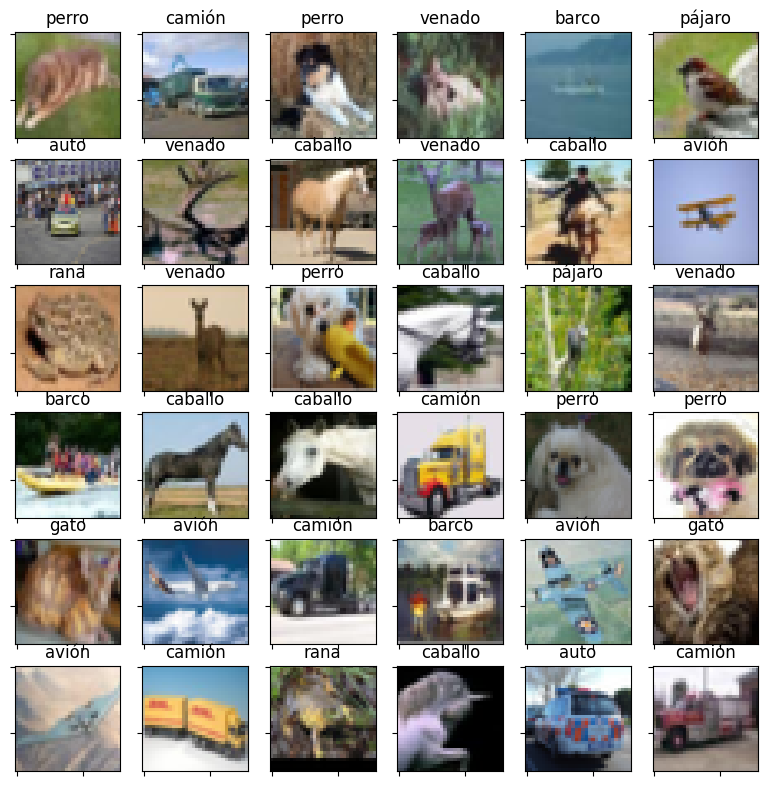

In [3]:
# Mostramos una grilla de ejemplos (al azar) del conjunto de test

h = 6 # alto de la grilla
w = 6 # ancho de la grilla
fig, axs = plt.subplots(h, w, figsize=(1.6*h,1.6*w))
for i in range(h):
  for j in range(w):
    ex = np.random.randint(len(imgs_test))
    axs[i,j].set_title(nombres[labs_test[ex][0]])
    axs[i,j].grid(False)
    axs[i,j].set_xticklabels([])
    axs[i,j].set_yticklabels([])
    axs[i,j].imshow(imgs_test[ex])

In [4]:
# Tranformamos los datos para el entrenamiento,
# Necesitamos transformar tanto el train como el test

X_train = imgs_train.reshape(50000,32*32*3)
X_test = imgs_test.reshape(10000,32*32*3)
X_train = X_train / 255
X_test = X_test / 255
print('X', X_train.shape, X_test.shape)

Y_train = keras.utils.to_categorical(labs_train, 10)
Y_test = keras.utils.to_categorical(labs_test, 10)
print('Y', Y_train.shape, Y_test.shape)

X (50000, 3072) (10000, 3072)
Y (50000, 10) (10000, 10)


In [5]:
# cantidad de ejemplos (train/test), neuronas de entrada y neuronas de salida

M_train = X_train.shape[0]
M_test = X_test.shape[0]

N = X_train.shape[1]
C = Y_train.shape[1]

print(N,C,M_train,M_test)

3072 10 50000 10000


In [6]:
# Setamos los seed para números random

np.random.seed(30)
tf.random.set_seed(30)


# Creamos nuestra red feed-forward (tiene 4 capas escondidas!)

h1 = 512
h2 = 256

red = keras.Sequential()
red.add(keras.layers.Dense(h1, input_dim=N, activation='relu'))
red.add(keras.layers.Dense(h2, activation='relu'))
red.add(keras.layers.Dense(h2, activation='relu'))
red.add(keras.layers.Dense(C, activation='softmax'))

red.summary()

red.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1573376   
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 1773066 (6.76 MB)
Trainable params: 1773066 (6.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [7]:
hist = red.fit(X_train, Y_train,
        epochs=150,
        batch_size=128,
        validation_data=(X_test,Y_test)
       )

Epoch 1/150
391/391 [==============================] - 5s 6ms/step - loss: 1.9869 - accuracy: 0.2910 - val_loss: 1.8641 - val_accuracy: 0.3370
Epoch 2/150
391/391 [==============================] - 2s 5ms/step - loss: 1.8214 - accuracy: 0.3568 - val_loss: 1.7866 - val_accuracy: 0.3683
Epoch 3/150
391/391 [==============================] - 2s 4ms/step - loss: 1.7491 - accuracy: 0.3846 - val_loss: 1.7174 - val_accuracy: 0.3870
Epoch 4/150
391/391 [==============================] - 2s 4ms/step - loss: 1.6954 - accuracy: 0.4028 - val_loss: 1.6831 - val_accuracy: 0.4120
Epoch 5/150
391/391 [==============================] - 2s 4ms/step - loss: 1.6567 - accuracy: 0.4185 - val_loss: 1.6283 - val_accuracy: 0.4249
Epoch 6/150
391/391 [==============================] - 2s 5ms/step - loss: 1.6206 - accuracy: 0.4313 - val_loss: 1.6657 - val_accuracy: 0.4051
Epoch 7/150
391/391 [==============================] - 2s 6ms/step - loss: 1.5912 - accuracy: 0.4402 - val_loss: 1.5939 - val_accuracy: 0.4281

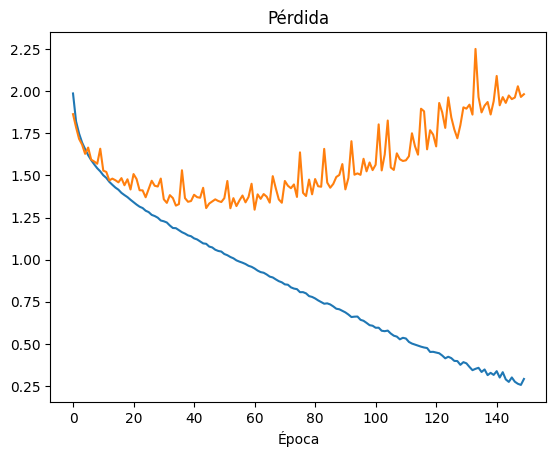

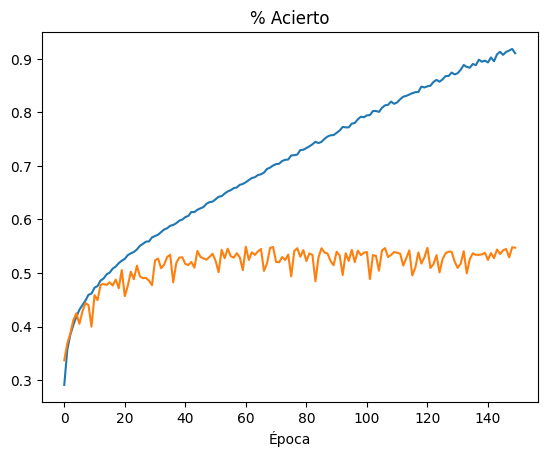

In [8]:
# Mostramos la pérdida y el acierto por cada época


#Este grafico (el primero) muestra en el grafico azul la funcion de costo (si decrementa es pq está aprendiendo) de los datos de train
#muestra en el grafico naranjo la funcion de costo (si decrementa es pq está aprendiendo) de los datos de test

#Costo de train decrementa, costo de test aumenta, esto es indicio de overfitting (memorización de test)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()

## Ejercicio  1: Regularización por Dropout

Para agregar  Dropout en keras simplemente usamos la capa `keras.layers.Dropout(p)` donde `p` es la probabilidad de dropout (de apagar una  neurona). Para agregar una de  estas capas simplemente usamos `add` como cualquier otra. Por ejemplo, podríamos hacer esto:

```
red_reg = keras.Sequential()
red_reg.add(keras.layers.Dense(30, input_dim=100, activation='relu'))
red_reg.add(keras.layers.Dropout(0.2))
red_reg.add(keras.layers.Dense(20, activation='relu'))
...
```

Note que agregamos una capa de dropout entre la primera y la segunda capa.

Crea una nueva red `red_reg` haciendo lo siguiente:
- Agrega una capa de dropout entre cada una de  las capas escondidas de la red usando un dropout entre 0.2 y 0.5.
- Entrena la red por 150 épocas para que veas cómo cambia el aprendizaje.
- Guarda la historia del  entrenamiento en una variable `hist_reg` para luego poder graficarla junto a la historia del entrenamiento anterior.
- Imprime el historial de la pérdida y el acierto para este nuevo entrenamiento.
- Imprime el acierto del entrenamiento con y sin regularización en un mismo  gráfico.

¿Obtienes mejores resultados en cuanto al acierto?

### a)  Crea y entrena la  red

In [ ]:
# Setamos los seed para números random

np.random.seed(30)
tf.random.set_seed(30)

red = keras.Sequential()
red.add(keras.layers.Dense(h1, input_dim=N, activation='relu'))
red.add(keras.layers.Dropout(0.3))
red.add(keras.layers.Dense(h2, activation='relu'))
red.add(keras.layers.Dropout(0.3))
red.add(keras.layers.Dense(h2, activation='relu'))
red.add(keras.layers.Dropout(0.3))
red.add(keras.layers.Dense(C, activation='softmax'))

red.summary()

red.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = red.fit(X_train, Y_train,
        epochs=150,
        batch_size=128,
        validation_data=(X_test,Y_test)
       )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 512)               1573376   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 10)               

### b) Imprime el historial de entrenamiento

In [ ]:
# Acá empieza tu código para mostrar el historial del nuevo entrenamiento

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()

# Acá termina tu código

### c) Compara el historial con y sin regularización

In [ ]:
# Acá empieza tu código para la comparación del acierto
# con y sin regularización


# Acá termina tu código.

### d) Muestra una grilla con ejemplos y las predicciones de la red

In [ ]:
# Acá empieza tu código para mostrar una grilla con ejemplos
# y la predicción de la red.
#Mostramos las predicciones
predictions = red.predict(X_test)
fig, axes = plt.subplots(5, 5, figsize=(15,15))
axes = axes.ravel()

for i in np.arange(0, 25):
    axes[i].imshow(X_test[i])
    axes[i].set_title("True: %s \nPredict: %s" % (np.argmax(y_test[i]), np.argmax(predictions[i])))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)


# Acá termina tu código.

## Ejercicio 2: Mejora el acierto en el test set

Usa lo que  has aprendido de regularización para intentar mejorar el acierto en el test set. Puede intentar con un dropout más agresivo, cambiando el tamaño del batch (más pequeño puede mejorar pero demora la ejecución!), aumentando la capacidad de tu red, etc.

Otro cambio  que puedes hacer es cambiar la tasa de aprendizaje.  Para eso puedes usar las funcionalidades en `keras.optimizers`.  Por ejemplo, para usar SGD con una tasa de aprendizaje de `0.001` puedes usar un código como este:

```
# primero creas la red
red = keras.Sequential()
...

# antes de compilar creas el optimizador
sgd_opt = keras.optimizers.SGD(lr=0.001)

# al compilar usas el optimizador
red.compile(
    loss='categorical_crossentropy',
    optimizer=sgd_opt,
    metrics=['accuracy']
)

# ahora puedes entrenar como siempre
red.fit(...)
...

```

Incluso puedes hacer búsqueda de hiperparámetros para encontrar la mejor red respecto del acierto en el test set. Para esto puedes programar un loop en donde vas probando la red para distintos hiperparámetros. Si lo haces ordenado y estás dispuesto a esperar, puedes encontrar redes que mejoren sustancialmente las métricas.

In [ ]:
np.random.seed(30)
tf.random.set_seed(30)

#creamos el optimizador ADAMAX
adamax_opt = keras.optimizers.Adamax(learning_rate=0.3)

red2 = keras.Sequential()
red2.add(keras.layers.Dense(h1, input_dim=N, activation='relu'))
red2.add(keras.layers.Dropout(0.5))
red2.add(keras.layers.Dense(h2, activation='relu'))
red2.add(keras.layers.Dropout(0.5))
red2.add(keras.layers.Dense(h2, activation='relu'))
red2.add(keras.layers.Dropout(0.3))
red2.add(keras.layers.Dense(C, activation='softmax'))

red2.summary()

red2.compile(
    loss='categorical_crossentropy',
    optimizer=adamax_opt,
    metrics=['accuracy']
)

hist2 = red2.fit(X_train, Y_train,
        epochs=60,
        batch_size=10,
        validation_data=(X_test,Y_test)
       )